### Install/Import libraries
We'll be using numpy, pandas, and xarray for preprocessing, matplotlib for vizualization, tensorflow to construct the model, and the last two are dependencies needed to open the dataset.

In [54]:
! pip install numpy pandas matplotlib xarray tensorflow netcdf4 xarray[io]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from tensorflow import keras
import os

In [3]:
filename = 'Mongolia_2D_ERA5_2010_2024.nc'
fullpath = os.path.join(os.getcwd(), 'Scorched Earth Data', filename)
dataset = xr.open_dataset(fullpath)
dataset

<xarray.Dataset> Size: 39MB
Dimensions:    (time: 5373, step: 24, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 40B 47.8 47.7 47.6 47.5 47.4
  * longitude  (longitude) float64 40B 106.4 106.5 106.6 106.7 106.8
  * step       (step) timedelta64[ns] 192B 01:00:00 02:00:00 ... 1 days 00:00:00
  * time       (time) datetime64[ns] 43kB 2009-12-31 2010-01-01 ... 2024-03-31
Data variables:
    d2m        (time, step, latitude, longitude) float32 13MB ...
    sp         (time, step, latitude, longitude) float32 13MB ...
    t2m        (time, step, latitude, longitude) float32 13MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 19 16:26:46 2024: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

### Preprocessing

In [4]:
clean_ds = dataset.dropna(dim="time", how="any")

In [5]:
days = clean_ds.coords['time'].shape[0]

rows = days * 24
hourly_t2m_ds = np.empty(shape=(rows))
hourly_d2m_ds = np.empty(shape=(rows))
hourly_sp_ds = np.empty(shape=(rows))

row = 0
for x in range(days):
	for y in range(24):
		hourly_t2m_ds[row] = clean_ds["t2m"][x, y, 2, 2]
		hourly_d2m_ds[row] = clean_ds["d2m"][x, y, 2, 2]
		hourly_sp_ds[row] = clean_ds["sp"][x, y, 2, 2]

		row += 1

In [6]:
clean_ds.coords["step"] = ["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00","08:00:00","09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00","18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00","23:00:00"]
dateTimeCoords = []
for date in clean_ds.coords["time"].values:
	for time in clean_ds.coords["step"].values:
		dateTime = str(date)[:11] + time
		dateTimeCoords.append(dateTime)

In [7]:
clean_hourly_ds = xr.Dataset(
    data_vars=dict(
        t2m=(["datetime"], hourly_t2m_ds),
        d2m=(["datetime"], hourly_d2m_ds),
		sp=(["datetime"], hourly_sp_ds),
    ),
    coords=dict(
        datetime=("datetime", np.array(dateTimeCoords, dtype='datetime64[h]'))
    ),
    attrs=dict(description="Hourly data from 2010-01-01 to 2024-03-30 at 47.6N 106.6E Ulaanbaatar, Mongolia."),
)

C:\Users\sguti\AppData\Local\Temp\ipykernel_10524\2520399145.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  clean_hourly_ds = xr.Dataset(


In [8]:
clean_hourly_ds["t2m"] = 9/5 * (clean_hourly_ds["t2m"] - 273.15) + 32
clean_hourly_ds["d2m"] = 9/5 * (clean_hourly_ds["d2m"] - 273.15) + 32
clean_hourly_ds["sp"] /= 100

### Feature Engineering

In [9]:
lag_time = 24
lead_time = 1
window = lag_time + lead_time

In [10]:
def make_supervised(dataset, lag_time, lead_time, dataset_size, features=1):
	# make_supervised(): Creates overlapping samples

	window = lag_time + lead_time 
	rows = dataset_size - window

	if features == 1:
		inputs = np.empty((rows, lag_time))
	else:
		inputs = np.empty((rows, lag_time, features))

	outputs = np.empty((rows, lead_time))

	for i in range(rows):
		x = dataset.iloc[i:(i+lag_time)]

		if features == 1:
			y = dataset.iloc[i+lag_time]
			inputs[i, :] = x
			outputs[i, :] = y
		else:
			y = dataset.iloc[i+lag_time]["t2m"]
			inputs[i, :, :] = x
			outputs[i, :] = y

	return inputs, outputs

In [11]:
clean_hourly_df = clean_hourly_ds.to_dataframe()
clean_hourly_df.head()

,t2m,d2m,sp
datetime,,,
2010-01-01 00:00:00,-10.466069,-15.221062,850.039375
2010-01-01 01:00:00,-8.896535,-13.519115,850.758750
2010-01-01 02:00:00,-4.705443,-11.755672,851.107500
2010-01-01 03:00:00,-1.632595,-10.515013,851.286875
2010-01-01 04:00:00,1.262605,-8.389434,851.213750


### Training, Validation, and Testing Sets

In [12]:
train_df = clean_hourly_df.loc["2010-01-01T00:00:00.000000000":"2020-12-31T23:00:00.000000000"]
valid_df = clean_hourly_df.loc["2021-01-01T00:00:00.000000000":"2023-12-31T23:00:00.000000000"]
test_df = clean_hourly_df.loc["2024-01-01T00:00:00.000000000":"2024-03-31T23:00:00.000000000"]

In [13]:
X_train, y_train = make_supervised(train_df["t2m"], lag_time, lead_time, len(train_df["t2m"]))
X_valid, y_valid = make_supervised(valid_df["t2m"], lag_time, lead_time, len(valid_df["t2m"]))
X_test, y_test = make_supervised(test_df["t2m"], lag_time, lead_time, len(test_df["t2m"]))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(93191, 24)
(93191, 1)
(25391, 24)
(25391, 1)
(2087, 24)
(2087, 1)


In [14]:
X_train_min = X_train.min()
X_train_max = X_train.max()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_valid = (X_valid - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

## Modeling

### Baseline Model

In [15]:
def baseline_model(X_test):
	predictions = []
	for i in range(X_test.shape[0]):
		predictions.append(X_test[i][-1])
	return np.array(predictions)

In [16]:
norm_predictions = baseline_model(X_test)
# Revert to original scale
predictions = (X_train_max - X_train_min) * norm_predictions + X_train_min

mse = 0
n = y_test.shape[0]
for i in range(n):
	mse += np.square((y_test[i] - predictions[i]))
mse /= n
print(f'Mean Square Error: {mse[0]:.3f}')

Mean Square Error: 6.376


### Univariate LSTM Model

An Long Short-Term Mwmory network is commonly used for forecasting. Typically used for natural language processing, but they can also be used for any time-series forecast context. The LSTM is comprised of units that contain an input gate, an output gate, and a forget gate. This structure helps with retaining useful information while discarding useless information over long period of time. The univariate model will serve as a baseline for more complicated LSTM models. It will only take the 2 meter temperature data to predict the future temperature.

TensorFlow has the Keras API that makes it easy to build deep learning models.

In [95]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM

The batch size is the number of training samples before the model is updated. A commonly used batch size is 32, but tests will have to be made to find the optimal batch size.

The LSTM will take the previous 24 hours as input and then return the temperature at the last time step.

In [21]:
batch_size = 32
input_length = lag_time
variables = 1

uni_lstm_model = Sequential()
uni_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
uni_lstm_model.add(LSTM(units=36, activation='relu', return_sequences=False))
uni_lstm_model.add(Dense(1))

The compile_and_fit function will set the loss, optimizer, any metrics, and train the model. The function has an option to interrupt the training early if the model's performance is not improving after a certain amount of epochs.

In [22]:
MAX_EPOCHS = 10

def compile_and_fit(model, X_train, y_train, X_valid, y_valid, patience=5):
  # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
	# 											patience=patience,
	# 											mode='min')

  model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.Adam(),
                metrics=[keras.metrics.MeanAbsoluteError()])

  print(model.summary())
  
  history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                      validation_data=(X_valid, y_valid))
                      # callbacks=[early_stopping])
  return history

In [23]:
history = compile_and_fit(uni_lstm_model, X_train, y_train, X_valid, y_valid)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (32, 36)               │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,509 (21.52 KB)

 Trainable params: 5,509 (21.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 231.4034 - mean_absolute_error: 10.0273 - val_loss: 59.7139 - val_mean_absolute_error: 6.1401
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 41.6748 - mean_absolute_error: 4.9680 - val_loss: 11.5517 - val_mean_absolute_error: 2.6566
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 10.6284 - mean_absolute_error: 2.4972 - val_loss: 6.2101 - val_mean_absolute_error: 1.7747
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7.3471 - mean_absolute_error: 2.0407 - val_loss: 4.9785 - val_mean_absolute_error: 1.6206
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 6.0335 - mean_absolute_error: 1.8454 - val_loss: 5.0979 - val_mean_absolute_error: 1.7331
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4.8378 - mean_absolute_error: 1.6497 - val_loss: 3.4536 - val_mean_absolute_error: 1.3505
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 3.5684 

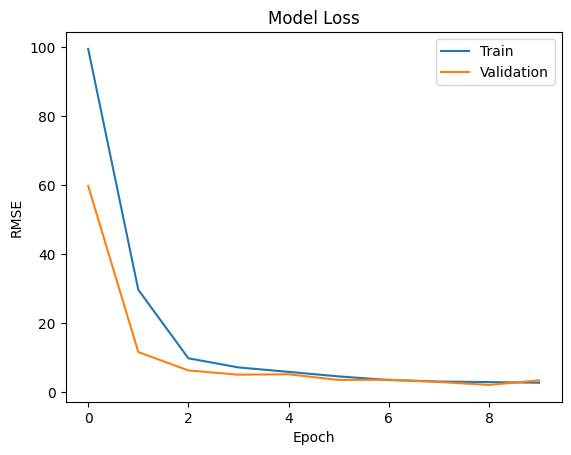

In [24]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [88]:
predictions = uni_lstm_model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


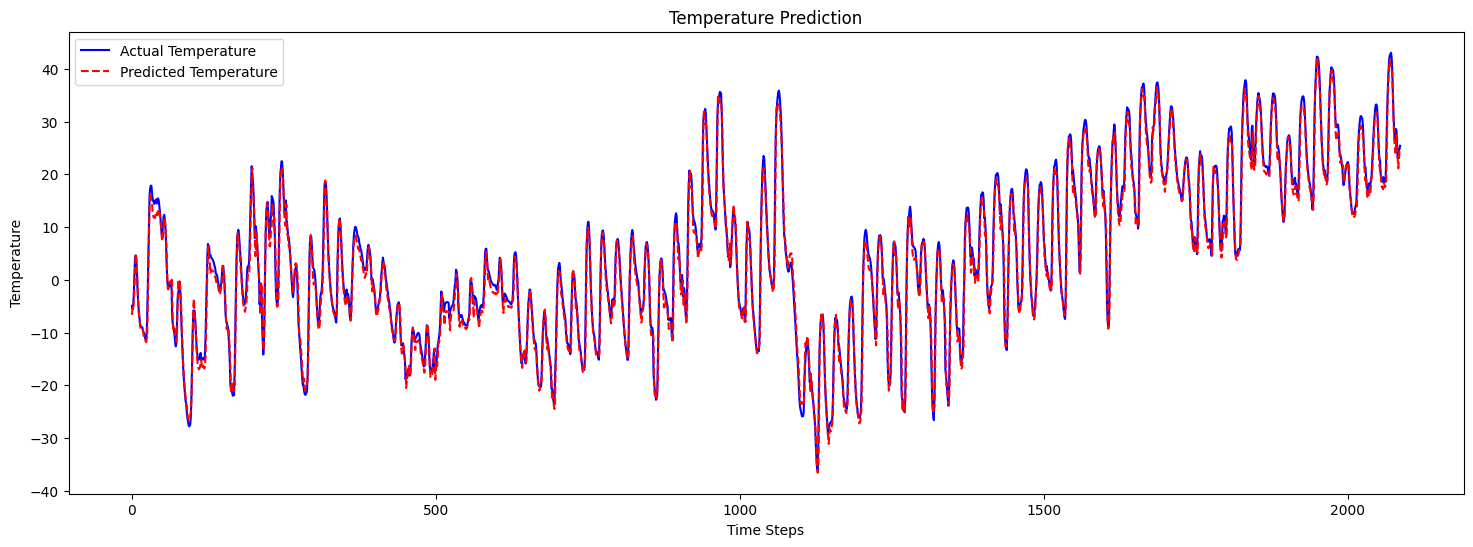

In [26]:
plt.figure(figsize=(18,6))
plt.plot(y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

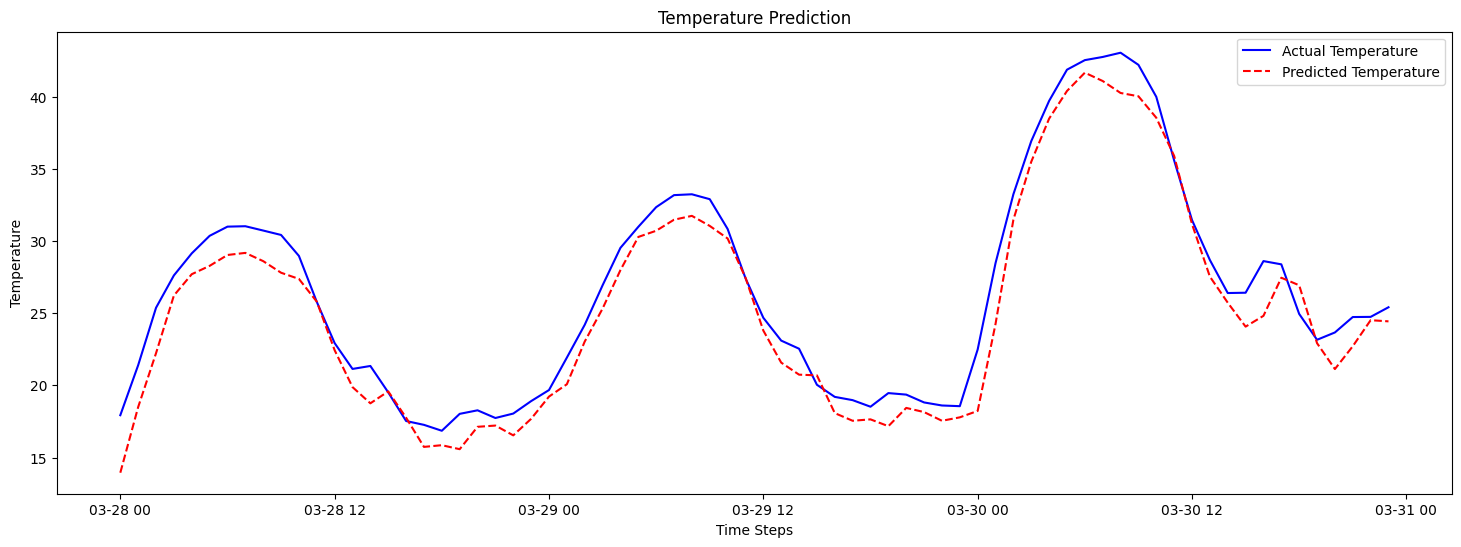

In [27]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Multivariate LSTM Model

In [65]:
multi_train_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2010-01-01T00:00:00':'2020-12-31T23:00:00']
multi_valid_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2021-01-01T00:00:00':'2023-12-31T23:00:00']
multi_test_df = clean_hourly_df[['t2m', 'd2m', 'sp']].loc['2024-01-01T00:00:00':'2024-03-31T23:00:00']

In [66]:
print(multi_train_df.shape)
print(multi_valid_df.shape)
print(multi_test_df.shape)

(93216, 3)
(25416, 3)
(2112, 3)


In [68]:
multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0], 3)
multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0], 3)
multi_X_test, multi_y_test = make_supervised(multi_test_df, lag_time, lead_time, multi_test_df.shape[0], 3)

In [69]:
X_train_min = multi_X_train.min()
X_train_max = multi_X_train.max()

multi_X_train = (multi_X_train - X_train_min) / (X_train_max - X_train_min)
multi_X_valid = (multi_X_valid - X_train_min) / (X_train_max - X_train_min)
multi_X_test = (multi_X_test - X_train_min) / (X_train_max - X_train_min)

In [70]:
batch_size = 32
input_length = lag_time
variables = 3

multi_lstm_model = Sequential()
multi_lstm_model.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model.add(LSTM(units=36, activation='relu', return_sequences=False))
multi_lstm_model.add(Dense(1))

In [71]:
multi_history = compile_and_fit(multi_lstm_model, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (32, 36)               │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 1)                │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,797 (22.64 KB)

 Trainable params: 5,797 (22.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 265.5109 - mean_absolute_error: 11.3769 - val_loss: 78.1397 - val_mean_absolute_error: 7.0089
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 61.2410 - mean_absolute_error: 6.1573 - val_loss: 50.2353 - val_mean_absolute_error: 5.4999
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 45.4663 - mean_absolute_error: 5.2689 - val_loss: 35.3971 - val_mean_absolute_error: 4.6101
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 38.0096 - mean_absolute_error: 4.8062 - val_loss: 32.6571 - val_mean_absolute_error: 4.4777
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 31.4485 - mean_absolute_error: 4.3802 - val_loss: 22.1216 - val_mean_absolute_error: 3.6655
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 24.2771 - mean_absolute_error: 3.8496 - val_loss: 16.9755 - val_mean_absolute_error: 3.1742
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 

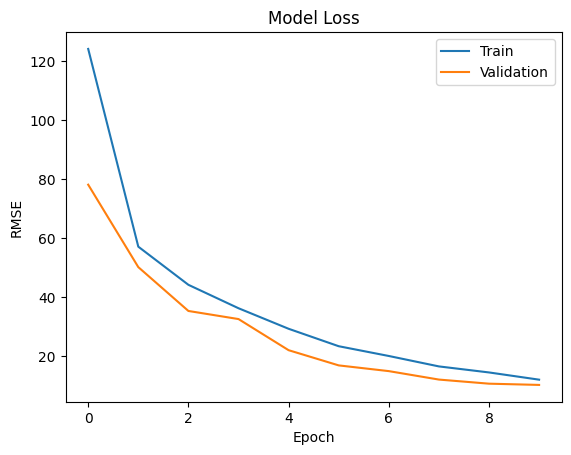

In [73]:
plt.plot(multi_history.history['loss'], label='Train')
plt.plot(multi_history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [74]:
predictions = multi_lstm_model.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


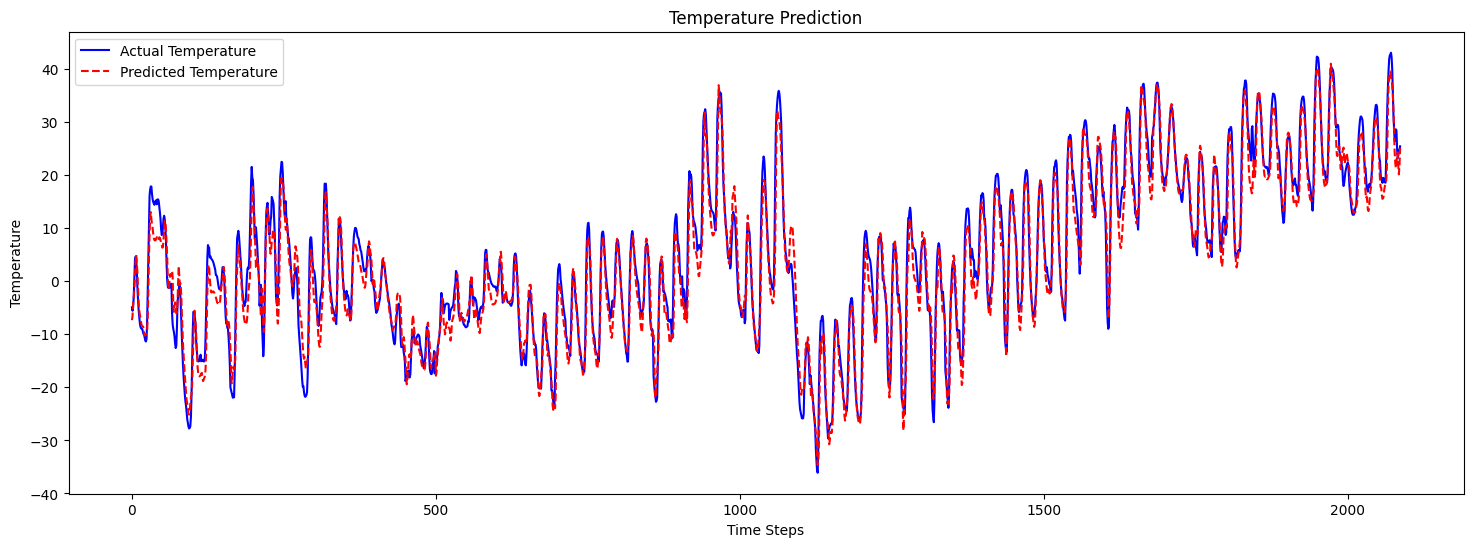

In [75]:
plt.figure(figsize=(18,6))
plt.plot(multi_y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

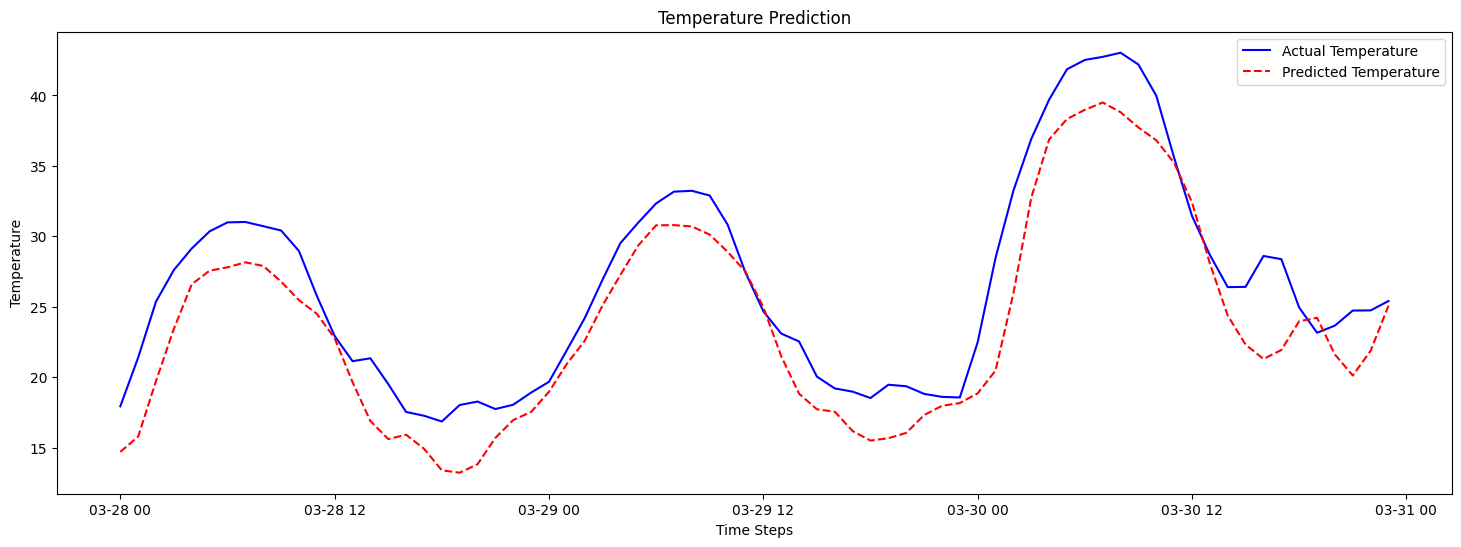

In [76]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], multi_y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [81]:
batch_size = 32
input_length = lag_time
variables = 3

multi_lstm_model_2 = Sequential()
multi_lstm_model_2.add(Input(shape=(input_length, variables), batch_size=batch_size))
multi_lstm_model_2.add(LSTM(units=36, activation='relu', return_sequences=True))
multi_lstm_model_2.add(LSTM(units=12, activation='relu', return_sequences=False))
multi_lstm_model_2.add(Dense(1))

In [82]:
multi_history = compile_and_fit(multi_lstm_model_2, multi_X_train, multi_y_train, multi_X_valid, multi_y_valid)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (32, 24, 36)           │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (32, 12)               │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 1)                │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,125 (31.74 KB)

 Trainable params: 8,125 (31.74 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - loss: 280.8601 - mean_absolute_error: 11.6890 - val_loss: 71.2661 - val_mean_absolute_error: 6.7267
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 57.0726 - mean_absolute_error: 5.9859 - val_loss: 49.0768 - val_mean_absolute_error: 5.5887
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 28.7049 - mean_absolute_error: 4.1714 - val_loss: 8.2965 - val_mean_absolute_error: 2.1218
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 8.8483 - mean_absolute_error: 2.2987 - val_loss: 7.3006 - val_mean_absolute_error: 2.2108
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 5.5842 - mean_absolute_error: 1.8141 - val_loss: 2.7205 - val_mean_absolute_error: 1.1874
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 3.7297 - mean_absolute_error: 1.4727 - val_loss: 2.6350 - val_mean_absolute_error: 1.1548
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 

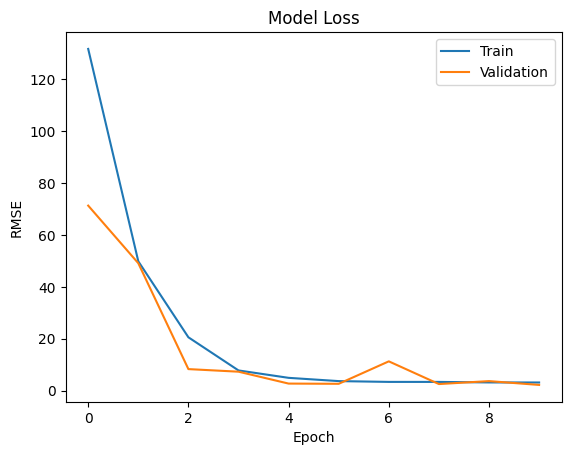

In [83]:
plt.plot(multi_history.history['loss'], label='Train')
plt.plot(multi_history.history['val_loss'], label='Validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend()
plt.show()

In [85]:
multi_predictions = multi_lstm_model_2.predict(multi_X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


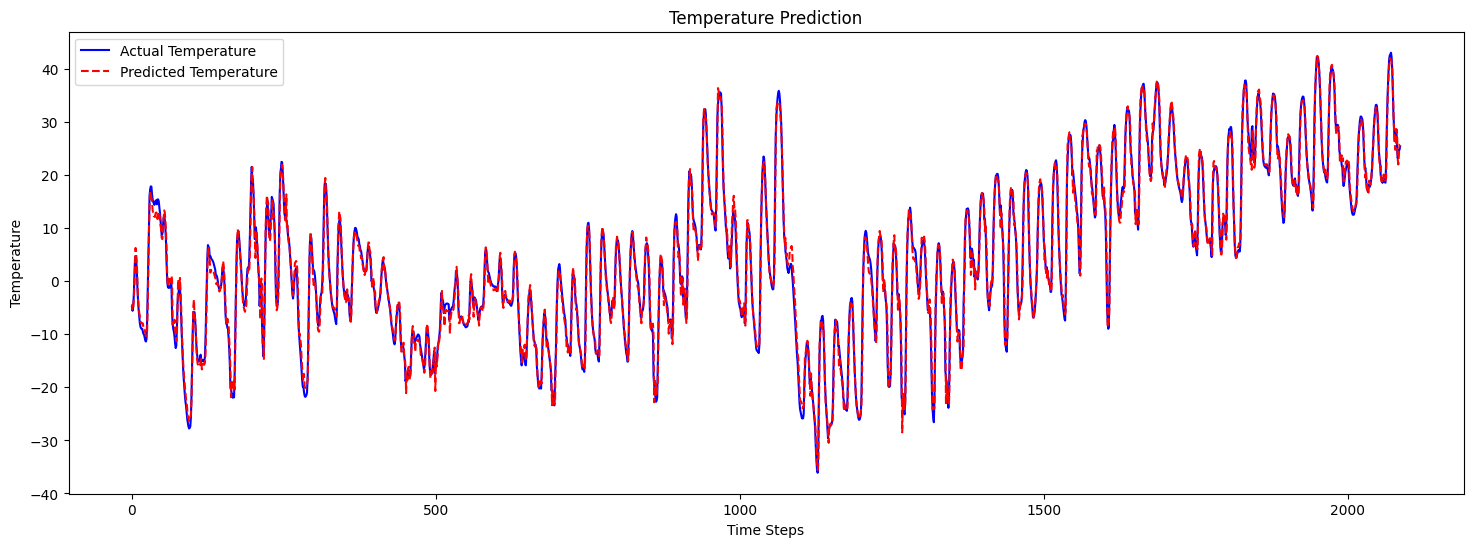

In [86]:
plt.figure(figsize=(18,6))
plt.plot(multi_y_test, color='blue', label='Actual Temperature')
plt.plot(multi_predictions, color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

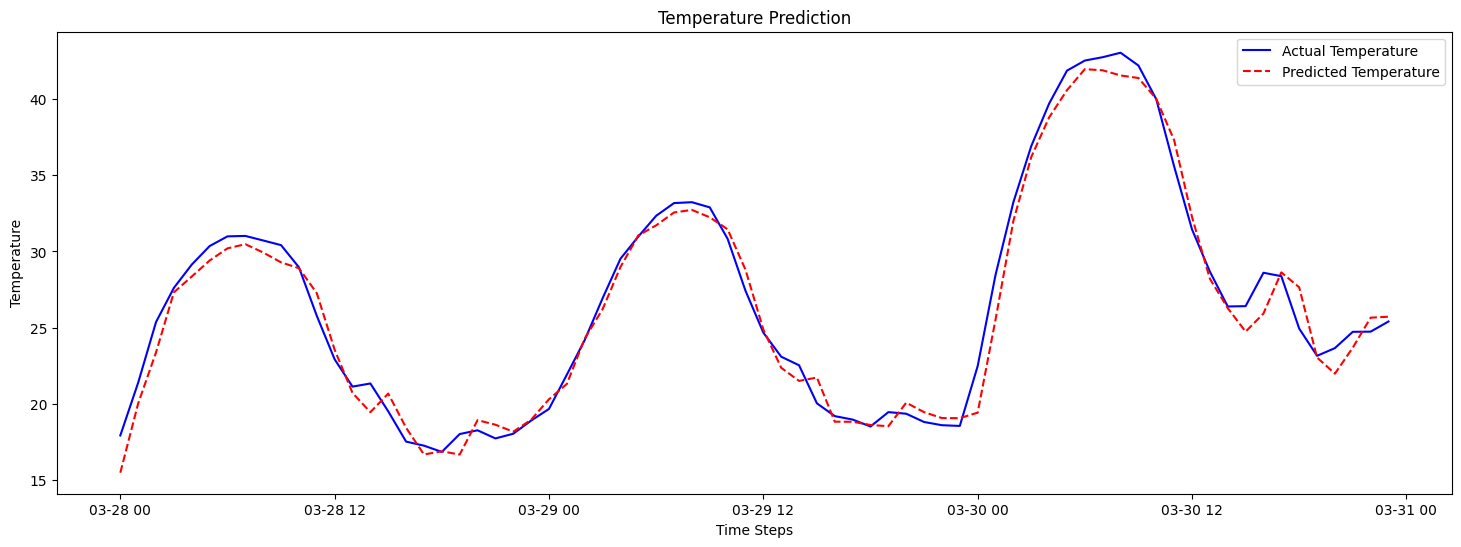

In [87]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], multi_y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='red', linestyle='--', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Univariate and Multivariate Model Comparison

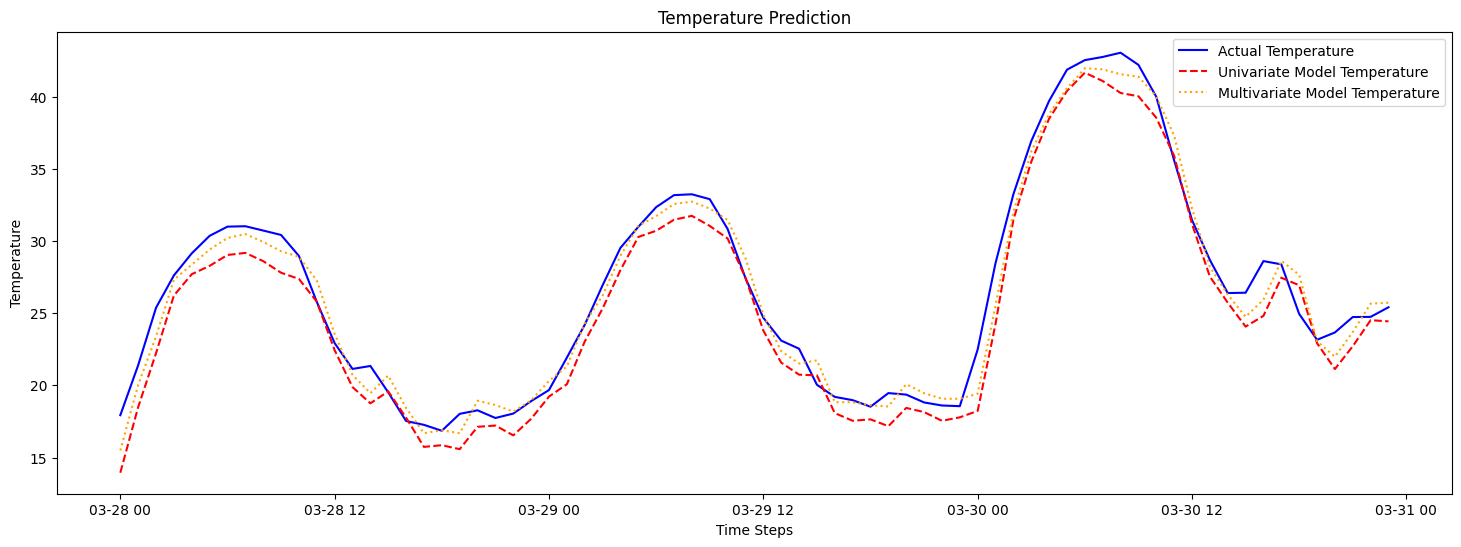

In [92]:
plt.figure(figsize=(18,6))
plt.plot(test_df.index[-72:], multi_y_test[-72:], color='blue', label='Actual Temperature')
plt.plot(test_df.index[-72:], predictions[-72:], color='red', linestyle='--', label='Univariate Model Temperature')
plt.plot(test_df.index[-72:], multi_predictions[-72:], color='orange', linestyle='dotted', label='Multivariate Model Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [94]:
print("Univariate Loss", history.history['loss'][-1])
print("Univariate Validation Loss", history.history['val_loss'][-1])
print("Multivariate Loss", multi_history.history['loss'][-1])
print("Multivariate Validation Loss", multi_history.history['val_loss'][-1])

Univariate Loss 2.6577508449554443
Univariate Validation Loss 3.3334197998046875
Multivariate Loss 3.1394686698913574
Multivariate Validation Loss 2.2047510147094727


While the multivariate LSTM model's training loss is lower than the univariate, it performed better on the validation set. Yet, the multivariate LSTM model is marginally better. To further decrease the loss, it would be more productive to do feature engineering and feature selection rather than adding more complexity to the model.

### Feature Selection

To find the optimal set of features, I will use best subset selection. It is a brute-force approach that searches for all 2^(# of features) to find the combination of features that minimizes the loss. The number of features available (5) is relatively low, so it is not too computationally expensive. There are less expensive appraches such as forward and backward subset selection, but they do not guarantee an optimal solution.

In [ ]:
predictors = 5

# 32 sets of predictors
power_set = {
	1: [['t2m'], ['d2m'], ['sp'], ['u10'], ['v10']],
	2: [['t2m', 'd2m'], ['t2m', 'sp'], ['t2m', 'u10'], ['t2m', 'v10'], ['d2m', 'sp'], ['d2m', 'u10'], ['d2m', 'v10'], ['sp', 'u10'], ['sp', 'v10'], ['u10', 'v10']],
	3: [['t2m', 'd2m', 'sp'], ['t2m', 'd2m', 'u10'], ['t2m', 'd2m', 'v10'], ['t2m', 'sp', 'u10'], ['t2m', 'sp', 'v10'], ['t2m', 'u10', 'v10'], ['d2m', 'sp', 'u10'], ['d2m', 'sp', 'v10'], ['d2m', 'u10', 'v10'], ['sp', 'u10', 'v10']],
	4: [['t2m', 'd2m', 'sp', 'u10'], ['t2m', 'd2m', 'u10', 'v10'], ['t2m', 'd2m', 'sp', 'v10'], ['d2m', 'sp', 'u10', 'v10'], ['t2m', 'sp', 'u10', 'v10']],
	5: [['t2m', 'd2m', 'sp', 'u10', 'v10']]
}

k_best_models = {}

print("Start training")
for k in range(1, predictors+1):
	# Fit all (p, k) models that contain exactly k predictors.
	kth_best_model = []
	print("Currently: K=", k)
	for set in power_set[k]:
		print("Currently: Set=", set)
		multi_train_df = clean_hourly_df[set].loc['2010-01-01T00:00:00':'2022-12-31T23:00:00'] # Training period
		multi_X_train, multi_y_train = make_supervised(multi_train_df, lag_time, lead_time, multi_train_df.shape[0])

		history = compile_and_fit(uni_lstm_model, multi_X_train, multi_y_train)
		mse = min(history.history['loss'])
	
		# Pick the best among these (p, k) models.
		if len(kth_best_model) == 0:
			kth_best_model = (set, mse)
		else:
			if kth_best_model[1] > mse:
				kth_best_model = (set, mse)
	k_best_models[k] = kth_best_model

print("Start validating")
# Select a single best model from among M_0, .., M_p. Same procedure as before but on a validation set
best_model = []
for set, mse in k_best_models:
	print("Subset: ", set)
	multi_valid_df = clean_hourly_df[set].loc['2023-01-01T00:00:00':'2023-12-31T23:00:00'] # Validation period
	multi_X_valid, multi_y_valid = make_supervised(multi_valid_df, lag_time, lead_time, multi_valid_df.shape[0])

	history = compile_and_fit(uni_lstm_model, multi_X_valid, multi_y_valid)
	val_mse = min(history.history['val_loss'])
	if len(best_model) == 0:
			best_model = (set, val_mse)
	else:
		if best_model[1] > val_mse:
			best_model = (set, val_mse)

print('Best predictors:', best_model[0])
print('Best model loss:', best_model[1])